![Randomforest](figs/rf_title.png)

Author: Michaela Wenner (wenner@vaw.baug.ethz.ch) 
<p style="text-align: right"> 
    <a href="https://medium.com/tech-vision/random-forest-classification-with-h2o-python-for-beginners-b31f6e4ccf3c">Figure Source</a> </p>

Literature:
* James, G., Witten, D., Hastie, T. and Tibshirani, R., 2013. [An introduction to statistical learning (Vol. 112)](https://www-bcf.usc.edu/~gareth/ISL/ISLR%20First%20Printing.pdf). New York: springer. 
* Breiman, L., 2017. [Classification and regression trees](https://www.taylorfrancis.com/books/9781351460491). Routledge.
* Breiman, L., 2001. [Random forests](https://link.springer.com/article/10.1023/A:1010933404324). Machine learning, 45(1), pp.5-32.

Tutorials:
* [Introduction](https://github.com/WillKoehrsen/Machine-Learning-Projects/blob/master/Random%20Forest%20Tutorial.ipynb)
* [In-Depth: Decision Trees and Random Forests](https://jakevdp.github.io/PythonDataScienceHandbook/05.08-random-forests.html)
* [Parameter Tuning](https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74)


# In this notebook

Here, we introduce decision trees and random forests as classifiers and make use of the algorithms to classify a handpicked catalog of seismic data. We will learn how a decision tree is build and what parameters can be changed to improve test results. Additionally, we are going to have a look at how ensemble methods can improve classification results and apply Random Forest to actual seismic data.

### Outline:

* Decision trees as classifier
* Ensemble methods: Random Forest
* Classification of seismic signals

## Please fill out the survey! :-)

https://www.surveymonkey.de/r/Z5SF7ZJ

In [1]:
# Configuration setup (run before doing anything else)

%matplotlib notebook
#Loading packages
import obspy
from obspy import UTCDateTime
import matplotlib.pyplot as plt
import scipy
import numpy as np
import pandas as pd

import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

import warnings
warnings.filterwarnings('ignore')

sns.set_style('white')

<img align="right" src="figs/dec_trees.png" width="500"> 

# Decision trees


Classification trees are **non-linear**, **non-parametric** classifiers that predict a **quantitative** response. Hence, the predictor space is divided into distinct non overlapping regions, each representing one class.

Each observation is than predicted to belong to one region. The class of the region is determined by the training data set.



### Terminology



**Nodes** 

-> Test for variables

**Leaves**

-> Classification result

*Fig. 1: From Introduction to Statistical Learning (a) Partition of feature space, not possible bin binary splitting (b) Example for feature space by binary splitting (c) Example of a decision tree for regions shown in b (d) 3rd dimension showing the "prediction surface"*



# Classification trees - Criterion for binary splits


### Classification error rate
-> fraction of training samples that do not belong to most common class in region

$$E = 1- \max_{k} \hat{p}_{mk}$$


$\hat{p}_{mk} $ = proportion of training observations in the mth region that are from the kth class

### Gini index
-> mesure of **total variance** across k-classes

$$G = \sum_{k=1}^{k} \hat{p}_{mk} (1-\hat{p}_{mk})$$


### Entropy
$$D = - \sum_{k=1}^{k} \hat{p}_{mk} log(\hat{p}_{mk})$$

Since $0 \leq \hat{p}_{mk} \leq 1$ it follows that $0 \leq -\hat{p}_{mk} log(\hat{p}_{mk})$

<IPython.core.display.Javascript object>


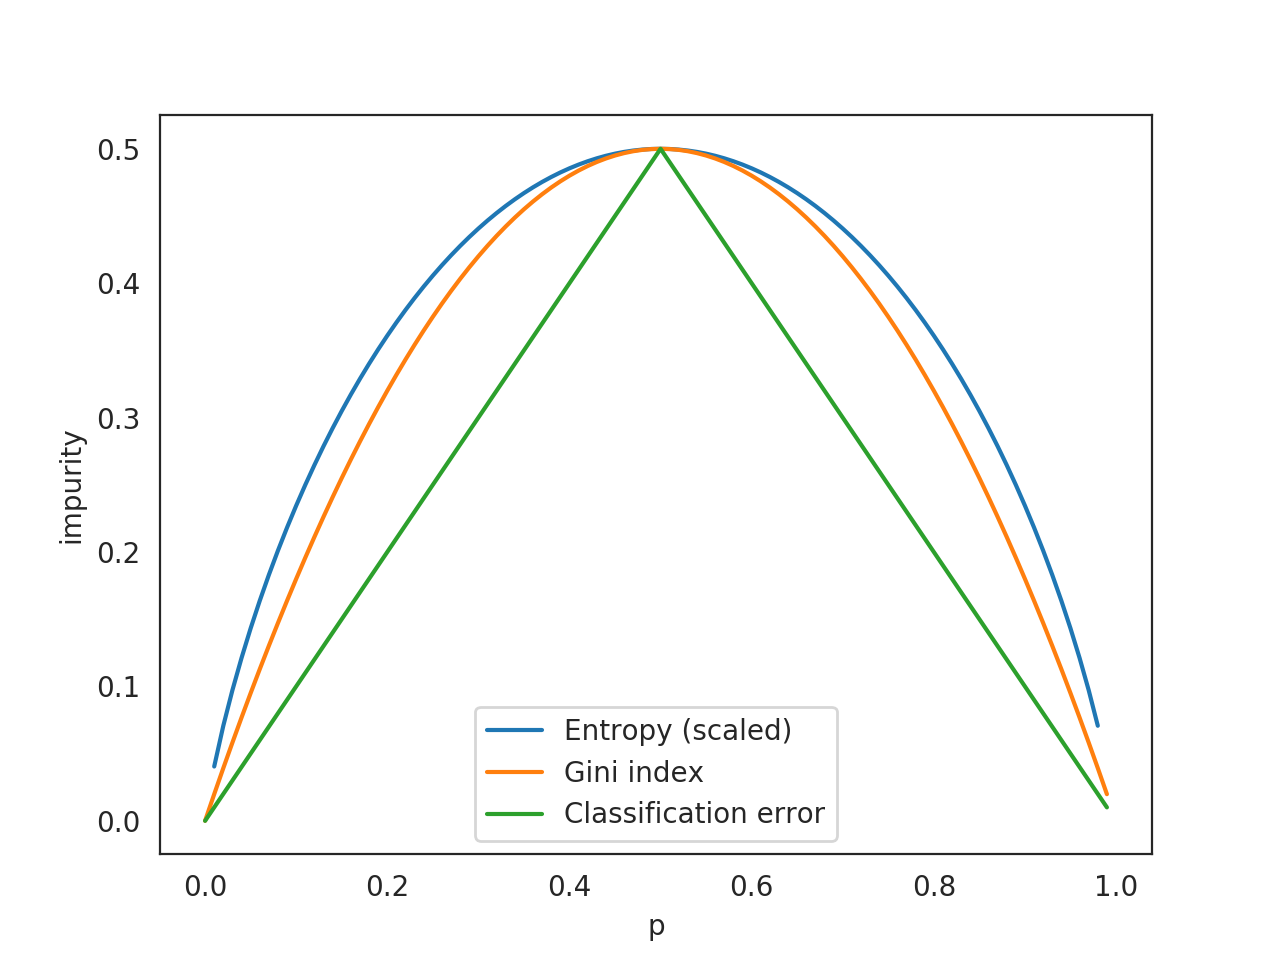

In [2]:
# Plot classification error rate, gini index and entropy

def class_error(p):
     return 1 - np.max([p, 1-p])
    
def gini_index(p):
    return p * (1-p) + (1-p) * (p)

def entropy(p):
    return - (p * np.log2(p) + (1-p)*np.log2(1-p))

x = np.arange(0.0, 1.0, 0.01)
x_ent = np.arange(0.01, 0.99, 0.01)
c_err = [class_error(i) for i in x]

fig = plt.figure()
plt.plot(x_ent, entropy(x_ent)/2, label = 'Entropy (scaled)')
plt.plot(x, gini_index(x), label = 'Gini index')
plt.plot(x, c_err, label = 'Classification error')
plt.xlabel('p')
plt.ylabel('impurity')
plt.legend()
plt.show()


<img align="right" src="figs/purity.png" width="400"> 


# Node purity



= Node contains predominantly **observations from a single class**

* Increases uncertainty for some predictions - decreases uncertainty for others

* Does not reduce the classification error

-> **Gini index** and **entropy** more sensitive to node purity

*Fig 2: regardless of the feature being >0.5 or not, the outcome will always be yes.*





# Classification Trees - basic example

* set of seismic events with different features


* two class problem: earthquake - noise (simplicity)


* two features (e.g. length, dominant frequency)

In [3]:
# Read csv file with features as first two column and event class as last column
columns = ['feature1', 'feature2','event_class']

# Read to data frame
df = pd.read_csv('material/table_decisiontree.csv', names=columns, dtype={'event_class':np.int32})

# Add event names to pandas data frame - also called qualitative/categorical/discrete variables
event_names = np.array(['noise', 'earthquake'])
tar = np.array(df['event_class'])
df['event'] = pd.Categorical.from_codes(tar, event_names)

# seperate noise and earthquake events dataframe
df_noise = df[df['event'] == 'noise']
df_eq = df[df['event'] == 'earthquake']


df.head()

,feature1,feature2,event_class,event
0,1,1,0,noise
1,1,2,0,noise
2,1,3,0,noise
3,2,1,1,earthquake
4,2,2,1,earthquake


In [4]:
# Define colors and cmap for data visualisation
colors = sns.diverging_palette(220, 20, n=2)
cmap = sns.diverging_palette(220, 20, center='dark', as_cmap=True)

<IPython.core.display.Javascript object>


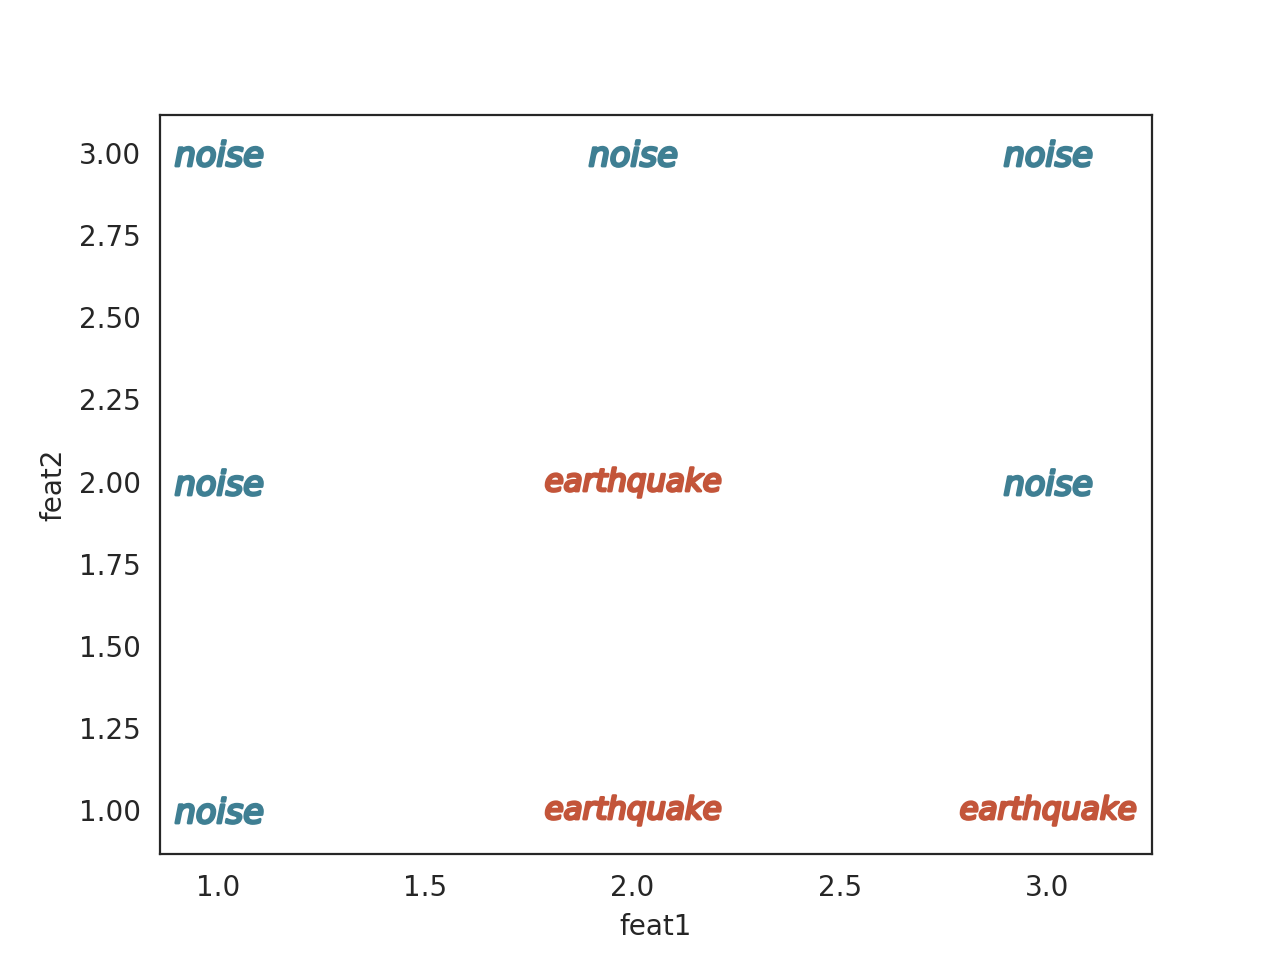

In [5]:
# Plot event features on two dimensional scatter plot
fig = plt.figure()
plt.scatter(df_noise['feature1'], df_noise['feature2'], color=colors[0], s = 1000,\
            marker=f"$ {df_noise['event'].iloc[0]} $")
plt.scatter(df_eq['feature1'], df_eq['feature2'], color=colors[1], s = 4000,\
            marker=f"$ {df_eq['event'].iloc[0]} $")
plt.ylabel('feat2')
plt.xlabel('feat1')
plt.show()

In [6]:
# Creat array of features and labels
features = df.columns[0:2]
X = np.asarray(df[features])
Y = np.asarray(df['event_class'])

print(f'Array of features \n {X}')
print(f'Array of labels \n {Y}')

Array of features 
 [[1 1]
 [1 2]
 [1 3]
 [2 1]
 [2 2]
 [2 3]
 [3 1]
 [3 2]
 [3 3]]
Array of labels 
 [0 0 0 1 1 0 1 0 0]


In [7]:
def visualize_classifier(classifier, X, Y, cmap=cmap):
    fig, ax = plt.subplots()
    
    plt.scatter(X[:, 0], X[:, 1], c=Y, s=50, cmap=cmap)

    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    
    xx, yy = np.meshgrid(np.linspace(*xlim, num=200),
                         np.linspace(*ylim, num=200))
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    # Create a color plot with classified areas
    n_classes = len(np.unique(Y))
    contours = ax.contourf(xx, yy, Z, alpha=0.3, levels=np.arange(n_classes + 1) - 0.5, cmap=cmap) 
    ax.contour(contours, colors= 'gray')

    ax.set(xlim=xlim, ylim=ylim)
    ax.set_xlabel('feat1',fontsize=12)
    ax.set_ylabel('feat2',fontsize=12)
    ax.tick_params(axis='both', labelsize=12)
    
    return fig

[Scikit-learn DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Define classifier
clf = DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_split=2, min_samples_leaf=1, \
                             max_leaf_nodes=None)

# Fit estimator on training data set
model = clf.fit(X,Y)  

<IPython.core.display.Javascript object>


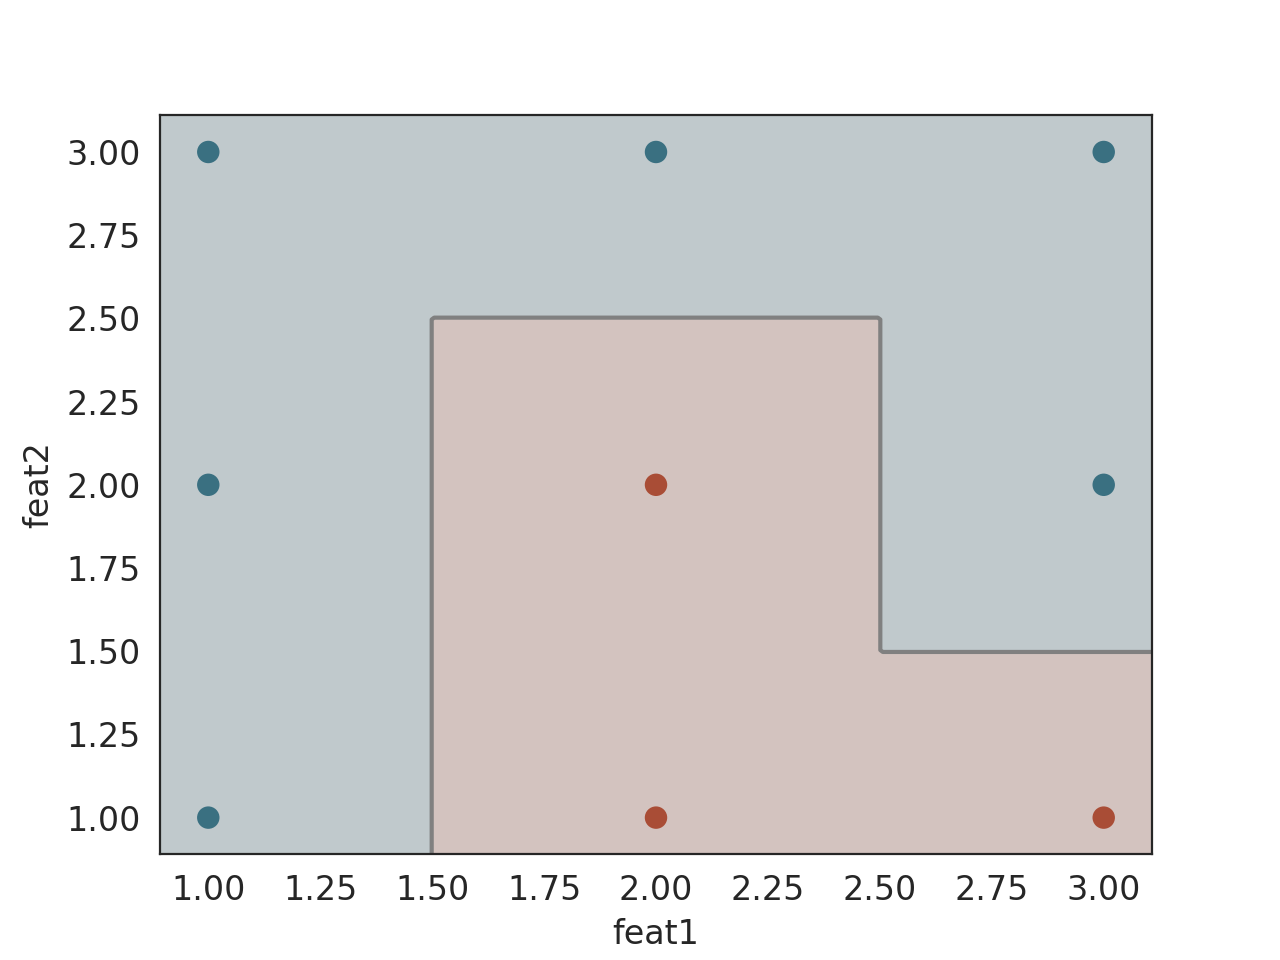

In [9]:
visualize_classifier(model, X, Y);

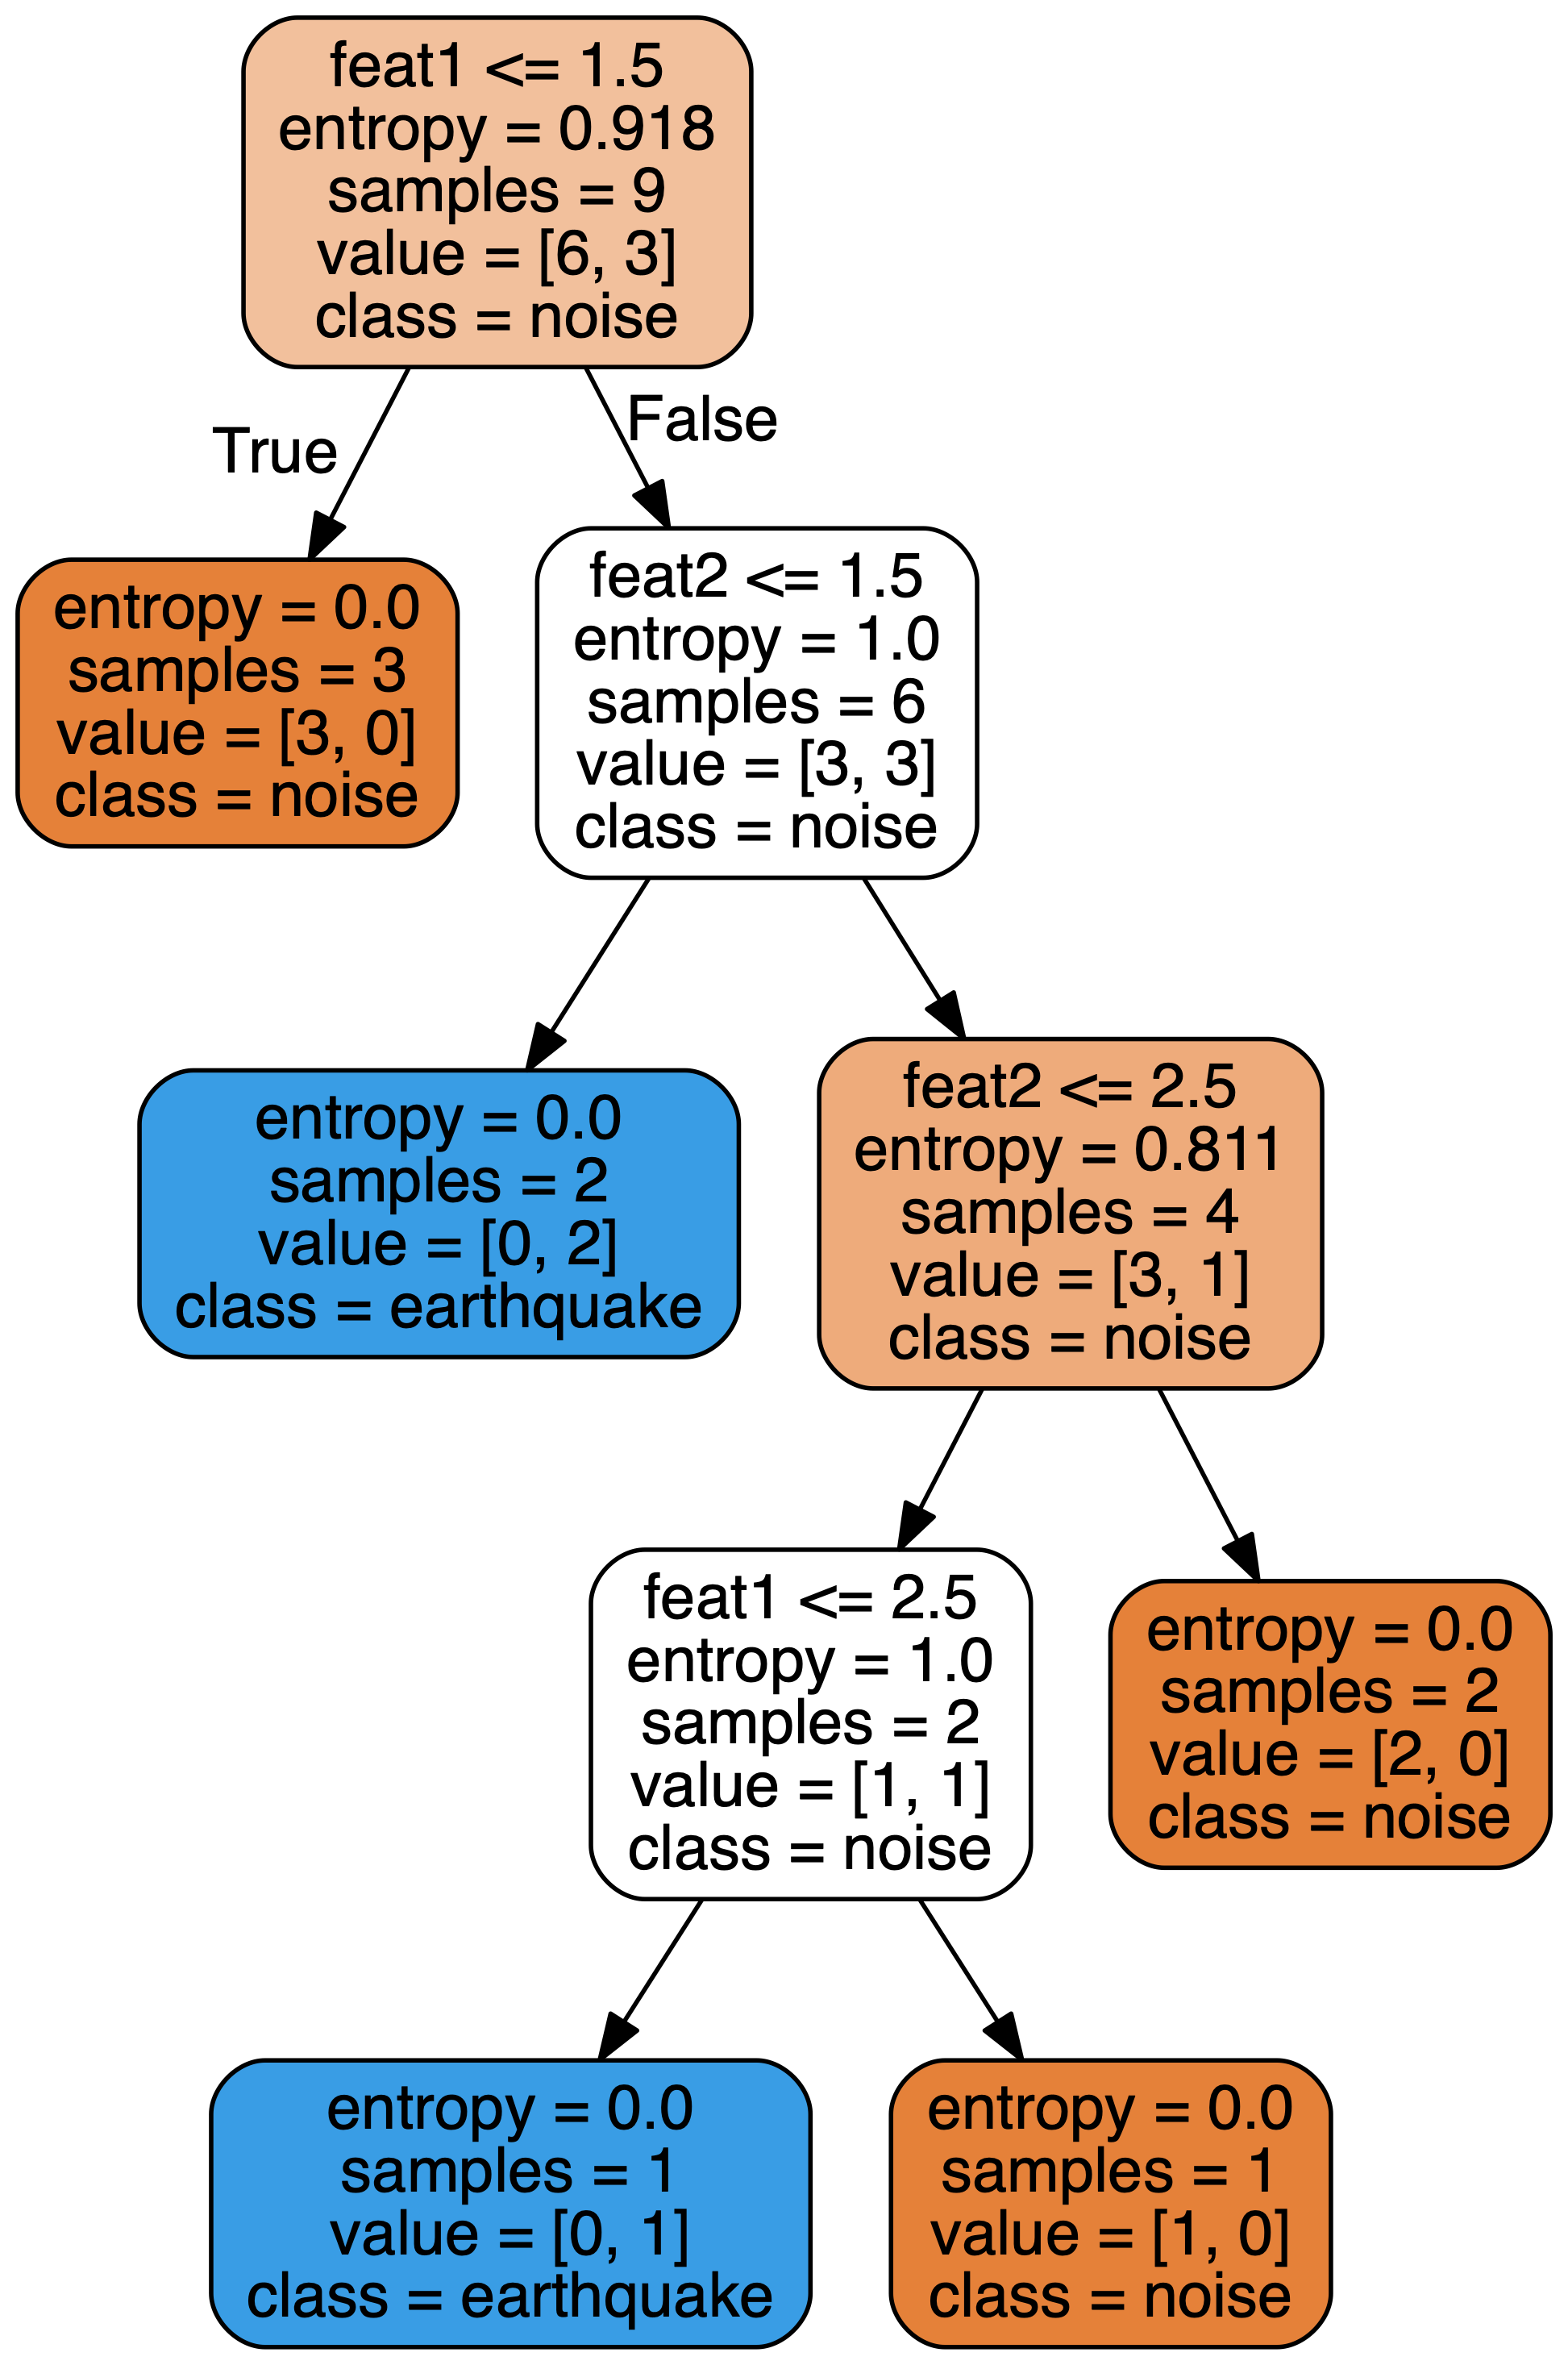

In [10]:
# Visualize decision tree
import graphviz
from sklearn import tree
from subprocess import call
from IPython.display import Image

dot_data = tree.export_graphviz(clf, out_file='figs/tree.dot', feature_names=['feat1', 'feat2'], \
                                class_names=['noise', 'earthquake'], filled=True, rounded=True,)

# Convert decision tree to png
call(['dot', '-Tpng', 'figs/tree.dot', '-o', 'figs/tree.png', '-Gdpi=400']);

# Display decision tree
Image('figs/tree.png', width=400)

In [ ]:
# Use blob data set for more realistic problem

from sklearn.datasets import make_blobs

# Define function to create data set of sample size n_samples
# Number of classes defined by centers
# Standard deviation of blobs in each class defined by cluster_std
# Creates interactive plot to visualize feature space for datasets with different std
def inter_tree(std):
    X, Y = make_blobs(n_samples=400, centers=3,
                  random_state=0, cluster_std=std)
    model = clf.fit(X,Y)
    visualize_classifier(model, X, Y)

interact(inter_tree, std=(0.0,2.0));

In [ ]:
a = [[0,1,0]]
class_names = ['blue', 'black', 'red']
for idx, cl in enumerate(a[0]):
    if cl == 1:
        print(class_names[idx])

In [ ]:
# Predicts probabilities for a give set of features
def pred_pro(feat1,feat2):
    class_names = ['blue', 'black', 'red']
    pred_proba = clf.predict_proba([[feat1,feat2]])
    
    [print("Predicted class:", class_names[idx]) for idx, cl in enumerate(pred_proba[0]) if cl == 1.]
    X, Y = make_blobs(n_samples=400, centers=3,
                  random_state=0, cluster_std=1)
    model = clf.fit(X,Y)
    visualize_classifier(model, X, Y)
    plt.plot(feat1, feat2, '*', color='yellow', markersize=15)
    
interact(pred_pro, feat1=(-4.0,4.0), feat2=(-4.0, 4.0));

In [ ]:
plt.close('all')

# Decision trees

| <p align="left.">PROS                         | CONS                         |
| --------------------------------------------- | ---------------------------- |
| <p align="left.">easy to understand           | predictive accuracy          |
| <p align="left.">can be graphically displayed | high variance                |   
| <p align="left.">computationally inexpensive  |                              |



Make use of PROS but get rid of CONS:

=> **Ensemble Methods**




# Ensemble Methods

Combine many (high complexity, low bias) models to reduce variane

### As a reminder

* We want to estimate some characteristic of a **probability distribution P**

  -> **Parameter** of P
  
  e.g. expected value, variance, kurtosis


* A parameter $\mu = \mu(P)$ is any function of the distribution P

* Suppose $D_n = (x_1, x_2,..., x_n)$ is an i.i.d (independent and identically distributed) sample from P

* A statistic $\hat{\mu} = \hat{\mu}(D_n)$ is a empirical estimator of $\mu$ if $\hat{\mu} \approx \mu$

  e.g. mean, median, variance, ...
  
Let $\mu$ : P -> R be a real-valued **parameter**

and $\hat{\mu}$ : $D_n$ ->  R be an empirical estimator of $\mu$

-> $\mu = \mu(P)$ and $\hat{\mu} = \hat{\mu}(D_n)$

* **Bias**: Bias($\hat{\mu}$) = $\mathbb{E}\hat{\mu} - \mu$

<b></b>



* **Variance**: Var($\hat{\mu}$) = $\mathbb{E}\hat{\mu}^2 - (\mathbb{E}\hat{\mu})^2$

<b></b>

* Estimator unbiased if Bias($\hat{\mu}$) = $\mathbb{E}\hat{\mu} - \mu$ = 0


### Bagging

-> standard method to **reduce variance**

-> increase prediction accuracy

Idea: 
* divide training data set $D_n$ of size n in B smaller, independent groups $D_{n/B}^1, D_{n/B}^2, .... D_{n/B}^B$
* build classifier for each individual training data set
* average resulting predictions

$$\hat{f}_{avg}(x) = \frac{1}{B} \sum_{i=1}^{B} \hat{f}_i(x)$$

#### Bias of average estimator

Bias does not increase when averaging over unbiased estimators

Set of estimators $\hat{f}_{1}(x), \hat{f}_{2}(x), ... , \hat{f}_{B}(x)$

$$Bias[\hat{f}_{avg}(x)]  = \frac{1}{B} \sum_{i=1}^{B} Bias[\hat{f}_{i}(x)]$$

#### Variance of average estimator

Variance decreases when averaging over estimators

Set of estimators $\hat{f}_{1}(x), \hat{f}_{2}(x), ... , \hat{f}_{B}(x)$

$$Var[\hat{f}_{avg}(x)] = \frac{1}{B^2} \sum_{i=1}^{B} Var [\hat{f}_i(x)] $$

**But:** Predictions itself would not be as good as if we used all data $D_n$

### Bootstrap

-> simulate having B independent training data sets of size n by drawing with replacement from $D_n$


$$\hat{f}_{bag}(x) = \frac{1}{B} \sum_{i=1}^{B} \hat{f}_{*i}(x)$$

In a bootstraped data set some elements
* will show up multiple times
* will not show up at all

### Out-of-Bag error estimation

observations that are not used by bootstrapped data set (out-of-bag) can be used to estimate test error




# Random forest

-> improvement of bagging: *decorrelates* trees by using a random subset of features at each split

Aggregation of many decision trees.

Each tree has less predictive power than the ensemble of the trees.


### Variable importance

Randomly change values of features and evaluate decrease in prediction accuracy



In [ ]:
# Define Random Forest Classifier and create model
from sklearn.ensemble import RandomForestClassifier

def inter_rf(std, n_est):
    clf_rf = RandomForestClassifier(n_estimators=n_est,max_features='auto', n_jobs=-1, min_samples_leaf = 1, \
                                    random_state=42, max_depth=None)


    X, Y = make_blobs(n_samples=400, centers=3,
                  random_state=0, cluster_std=std)
    model = clf_rf.fit(X,Y)
    visualize_classifier(model, X, Y)

interact(inter_rf, n_est=(1,200), std=(0.0,2.0));

In [ ]:
plt.close('all')

# Example - Classifying seismic data of mass movements

Over recent years, seismology has evolved into a standard tool to study temporal and spatial variability of mass movement prone areas. Increasing data volumes and the demand for near real-time monitoring call for automated techniques to detect and classify seismic signals generated by mass movements.

To classify different source mechanism of seismic signals, the signal has to be "simplified" in different ways to describe the waveform with one value. Such simplifications are the socalled features we have heard about before. 
For seismic signals, these can for example be the duration of the signal or the dominant frequencies.

The study site we will be working on is Illgraben in the southwest of Switzerland. The Illgraben catchment is one of the most active mass wasting sites in the European Alps, with numerous rock-slope failure events and several debris flows per year. The Figure shows the Illgraben with the seismic network (ILL*) and the mass wasting deposition area in red.

![Illgraben](figs/Illgraben_all.png)

For the classification problem, we define four different classes: 

* Earthquake
* Microquake
* Rock avalanche
* Noise

An event catalog of four month in 2017 contains all events that were recorded on the stations. Here, we will treat each signal that was recorded as a single event. For instance, a local earthquake that was recorded on 5 stations will be treated as 5 different events.
The event catalog was labeled and cross validated by experts and consists of starttime, endtime, duration, event type and the station it was recorded on.

## Example catalog - one event of each class recorded on several stations

In [ ]:
# Read catalog with four example events
cat_ex = pd.read_csv('material/event_catalog2017_example.txt', delimiter=' ', skiprows=1, \
                  names=['sdate', 'stime', 'edate', 'etime', 'duration', 'Type', 'station'])

# Add event names to pandas data frame - also called qualitative/categorical/discrete variables
event_names = np.array(['earthquake', 'microquake', 'rockavalanche', 'noise'])
tar = np.array(cat_ex['Type']) -1
cat_ex['event'] = pd.Categorical.from_codes(tar, event_names)

# Choose only events recorded on station ILL08
cat08 = cat_ex[cat_ex['station'] == 'XP.ILL08..EHZ']
cat08

cat_ex.head(10)

In [ ]:
# Remove response
def rere(st, inv):
    #preprocessing
    pre_filt = [0.005, 0.006, 45.0, 50.0]
    #st.trim(ev_time, end_time)
    st.remove_response(inventory = inv, pre_filt = pre_filt, \
            output = 'VEL', water_level = 60, plot=False)
    return st

# Plot waveform, spectra and spectrogram of event
def plotwaveyspec(st,fmin, fmax):
    tr = st[0]
    # Setup figure
    fig = plt.figure(figsize = (9, 5))
    # [left bottom width height] 
    ax1 = fig.add_axes([0.25, 0.1, 0.65, 0.2]) # WAVEFORM
    ax4 = fig.add_axes([0.1, 0.3, 0.15, 0.6]) # SPECTRUM
    ax2 = fig.add_axes([0.25, 0.3, 0.65, 0.6], sharex=ax1, sharey=ax4) # SPECTROGRAM
    ax3 = fig.add_axes([0.91, 0.3, 0.02, 0.6]) # COLORBAR

    cmap = plt.get_cmap('cividis')
    
    # Plot waveforms (left subfigure)
    #xt = tr.times()
    ax1.plot(tr.times(), tr.data, color=cmap.colors[0], label="%s" %tr.id)
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("Amplitude")
    ax1.set_xlim(0, tr.times()[-1])
    ax1.legend(loc=1)

    # Plot spectrogram (bottom right figure)
    fig = tr.spectrogram(wlen=0.00015*len(tr.data), cmap=cmap, show=False, axes=ax2)
    ax2.set_ylim(fmin, fmax)
    ax2.set_xlim(0, tr.times()[-1])

  
    # Plot colorbar
    mappable = ax2.images[0]
    plt.colorbar(mappable=mappable, cax=ax3)

    # Plot spectrum (top right figure)
    sp, fr, line, = ax4.magnitude_spectrum(tr.data, tr.stats.sampling_rate, visible=False)
    ax4.plot(sp,fr, color=cmap.colors[0])
    ax4.set_xlabel('Magnitude')
    ax4.set_xlim(min(sp), max(sp))
    ax4.invert_xaxis()
    ax4.set_ylabel('Frequency (Hz)')
    
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.setp(ax2.get_yticklabels(), visible=False)
    plt.setp(ax1.get_yticklabels(), visible=False)
    plt.setp(ax4.get_xticklabels(), visible=False)
    plt.setp(ax3.get_xticklabels(), visible=False)

    
    ax2.set_title("Station {} - {}".format(tr.stats.station,tr.stats.starttime.ctime()))
    #plt.tight_layout()
    plt.show()

In [ ]:
# Import inventory
inv = obspy.read_inventory('material/ILL1-8_inventory.xml')

# Prepare and plot data
for i in cat08.index.values:
    starttime = UTCDateTime('%sT%s' % (cat_ex['sdate'][i], cat_ex['stime'][i]))
    endtime = UTCDateTime('%sT%s' % (cat_ex['edate'][i], cat_ex['etime'][i]))
    station = cat_ex['station'][i][3:8]
    st = obspy.read(f'material/*{starttime.julday:03d}')
    st.trim(starttime-10, endtime+10)
    print(i, cat_ex['event'][i], st)
    rere(st, inv)
    st.detrend('linear')
    st.detrend('demean')
    st.taper(0.1)
    f_min = 1
    f_max = 30
    st.filter('bandpass', freqmin = f_min, freqmax = f_max)
    plotwaveyspec(st, f_min, f_max)


In [ ]:
# Calculate features for all traces in example catalog
import ComputeAttributes_MW

def attributes_all_traces(cat):
    all_char = {}
    for i in cat.index.values:
        ev_type = cat['Type'][i]
        starttime = UTCDateTime('%sT%s' % (cat['sdate'][i], cat['stime'][i]))
        endtime = UTCDateTime('%sT%s' % (cat['edate'][i], cat['etime'][i]))
        station = cat['station'][i][3:8]
        st = obspy.read(f'material/*{starttime.julday:03d}')
        st.trim(starttime, endtime)
        st.detrend('demean')
        print(i, st)
        rere(st, inv) 

        for tr in st:
            att = ComputeAttributes_MW.calculate_all_attributes(tr.data,tr.stats.sampling_rate)
            type_att = np.append(ev_type, att)
            all_char[i] = {'attributes': type_att, 'signal': st[0].data}


    return all_char
# Write attributes to dictionary with event class, attributes and signal of event

char = attributes_all_traces(cat_ex)

char[0]

In [ ]:
# Create array of event class and attributes
att_arr = np.vstack([char[x]['attributes'] for x in list(char.keys())])

# Save array to csv file
np.savetxt('material/example_attributes.csv', att_arr, delimiter=',')

In [ ]:
%matplotlib inline

# Read csv file with event class as first column and attributes as [1:8]
columns = ['event_class','duration', 'RappMaxMean', 'AsDec', 'DistDecAmpEnv', 'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT']

# Read to data frame
df = pd.read_csv('material/example_attributes.csv', names=columns,  dtype={'event_class':np.int32})
df['event_class'] = df['event_class'] -1

#Add event names
event_names = np.array(['earthquake', 'microquake', 'rockavalanche', 'noise'])
tar = np.array(df['event_class'])
df['event'] = pd.Categorical.from_codes(tar, event_names)


# Choose features to plot
features = df[['duration', 'RappMaxMean', 'MeanFFT', 'event']] 
from matplotlib import rcParams

# Make the pair plot of features with kernel density estiamtion on diagonal
sns.pairplot(features, hue = 'event', diag_kind = 'kde', plot_kws=dict(alpha = 0.5),
                   diag_kws=dict(shade=True), size=(4));




df.head(10)

## Full event catalog with 58 calculated attributes
after Provost, F., Hibert, C. and Malet, J.P., 2017. Automatic classification of endogenous landslide seismicity using the Random Forest supervised classifier. Geophysical Research Letters, 44(1), pp.113-120.

In [ ]:
# Read csv file with event class as first column and attributes as [1:59]
columns = ['event_class','duration', 'RappMaxMean','RappMaxMedian', 'AsDec', 'KurtoSig', \
                                               'KurtoEnv', 'SkewnessSig', 'SkewnessEnv', 'CorPeakNumber', 'INT1', \
                                               'INT2', 'INT_RATIO', 'ES[0]', 'ES[1]', 'ES[2]', 'ES[3]', 'ES[4]', 'KurtoF[0]', \
                                               'KurtoF[1]', 'KurtoF[2]', 'KurtoF[3]', 'KurtoF[4]', 'DistDecAmpEnv', \
                                               'env_max/duration(Data,sps)', 'MeanFFT', 'MaxFFT', 'FmaxFFT', \
                                               'FCentroid', 'Fquart1', 'Fquart3', 'MedianFFT', 'VarFFT', 'NpeakFFT', \
                                               'MeanPeaksFFT', 'E1FFT', 'E2FFT', 'E3FFT', 'E4FFT', 'gamma1', 'gamma2', \
                                               'gammas', 'SpecKurtoMaxEnv', 'SpecKurtoMedianEnv', 'RATIOENVSPECMAXMEAN', \
                                               'RATIOENVSPECMAXMEDIAN', 'DISTMAXMEAN', 'DISTMAXMEDIAN', 'NBRPEAKMAX', \
                                               'NBRPEAKMEAN', 'NBRPEAKMEDIAN', 'RATIONBRPEAKMAXMEAN', \
                                               'RATIONBRPEAKMAXMED', 'NBRPEAKFREQCENTER', 'NBRPEAKFREQMAX', \
                                               'RATIONBRFREQPEAKS', 'DISTQ2Q1', 'DISTQ3Q2', 'DISTQ3Q1']
# Read to data frame
df = pd.read_csv('material/all_attributes.csv', names=columns, dtype={'event_class':np.int32})
df['event_class'] = df['event_class'] -1

# Define actual names for events and append
event_names = np.array(['earthquake', 'microquake', 'rockavalanche', 'noise'])
tar = np.array(df['event_class'])
df['event'] = pd.Categorical.from_codes(tar, event_names)

df.head()

In [ ]:
# Choose features to plot
features = df[['duration', 'RappMaxMean', 'MeanFFT', 'event']] 

# Make the pair plot of features with kernel density estiamtion on diagonal
sns.pairplot(features, hue = 'event', diag_kind = 'kde', plot_kws=dict(alpha = 0.5),
                   diag_kws=dict(shade=True), size=(4));

df.head(10)

### [Scikit-learn RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)


In [ ]:
# Define nb of training samples
from sklearn.model_selection import train_test_split

test_sizes = [0.5, 0.4, 0.3, 0.1]
for nb in test_sizes:
    features = df.columns[1:58]
    y = np.asarray(df['event_class'])
    X = np.asarray(df[features])


    # Seperate train and test data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=nb, random_state=42)

    # Create a random forest Classifier
    clf = RandomForestClassifier(n_estimators=1400,criterion='gini',max_features='auto', \
                                 n_jobs=-1, min_samples_leaf = 1, max_depth=40, min_samples_split=2, \
                                 oob_score=True, random_state=None, bootstrap=True)

    # Train the Classifier 
    clf.fit(X_train, y_train)

        
    # Show the number of observations for the test and training dataframes
    print('Number of observations in the training data:', len(y_train))
    #print('Number of observations in the test data:',len(y_test))
    print(f'For {len(y_train)} training samples, the out-of-bag score is {clf.oob_score_}')

In [ ]:
clf_probs = clf.predict_proba(X_test)
clf_probs[0:5]

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=20)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    ax.tick_params(labelsize=15)
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black", fontsize=15)
    plt.ylabel('True label', fontsize=15)
    plt.xlabel('Predicted label', fontsize=15)
    plt.tight_layout()

In [ ]:
import itertools
from sklearn.metrics import confusion_matrix

# Apply the Classifier we trained to the test data (which, remember, it has never seen before)
pred = clf.predict(X_test)

cnf_matrix = confusion_matrix(y_test, pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=event_names, normalize=True,
                      title='Normalized confusion matrix', cmap=plt.cm.bone_r)


In [ ]:
# View a list of the features and their importance scores
xx = sorted(zip(df[features], clf.feature_importances_), key=lambda x: x[1], reverse=True)

[(i[0], i[1] / xx[0][1]) for i in xx]

In [ ]:
# Test model
def evaluate(model, test_features, test_labels):
    score = clf.score(test_features, test_labels)
    print('Model Performance')
    print('Score: {:0.4f}'.format(score))   
    return score

score = evaluate(clf, X_test, y_test)